In [43]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import decomposition

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import DenseNet121, VGG16
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score


import pathlib
from PIL import Image

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [44]:
# path for each partition of the data
data_directory = pathlib.Path('/Users/erdem/model-playground/data')

In [45]:
# creating a pathlib object for each partition
train_subdir = data_directory.joinpath("train")
validation_subdir = data_directory.joinpath("valid")
test_subdir = data_directory.joinpath("test")

In [46]:
training_images = [file for subdir in train_subdir.glob('*') for file in subdir.glob('*')]
validation_images = [file for subdir in validation_subdir.glob('*') for file in subdir.glob('*')]
test_images = [file for subdir in test_subdir.glob('*') for file in subdir.glob('*')]

print(f"Number of training examples: {len(training_images)}",
      f"\nNumber of validation examples: {len(validation_images)}",
f"\nNumber of test examples: {len(test_images)}")

Number of training examples: 5000 
Number of validation examples: 899 
Number of test examples: 902


checking the balance of the training set

We should check for the balance of the training set since it might affect model's performance drastically. Highly imbalanced datasets (as a rule of thumb, with classess whose size are less than 5% of the data) might tend to predict all observations to be from the majority class(and get a 95% or higher fake accuracy score).

In [47]:
# counting the number of observations per training labels
labels = []
image_count = []
for subdir in train_subdir.iterdir():
    count = 0
    label = subdir.name
    labels.append(label)
    for image in subdir.glob("*.jpg"):
        count += 1
    image_count.append(count)
print(f"there are {len(labels)} labels and {sum(image_count)} images in the data set\n")
print(labels,"-->", image_count)

there are 5 labels and 5000 images in the data set

['H2', 'H5', 'H3', 'H6', 'H1'] --> [1000, 1000, 1000, 1000, 1000]


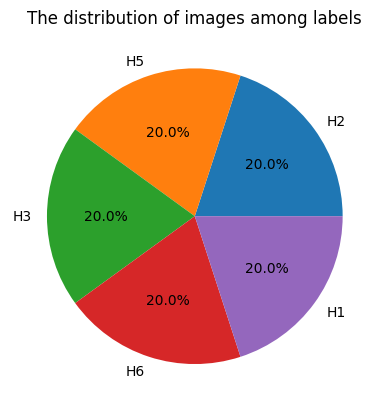

In [48]:
# using pie plot to show the distribution of training dataset images
plt.pie(image_count, labels = labels,autopct='%1.1f%%')
plt.title("The distribution of images among labels")
plt.show()

In [49]:
# creating a dictionary to store the metadata of all training set images
training_images_metadata = { "shapes" : [], "pixel_ranges" : []}
for image_path in training_images:
    img = Image.open(image_path)
    img_array = tf.keras.utils.img_to_array(img)
    shape = img_array.shape
    min_,max_ = img_array.min(), img_array.max()
    training_images_metadata["shapes"].append(shape)
    training_images_metadata["pixel_ranges"].append([min_,max_])

In [50]:
# finding the min and max value of pixel ranges and the unique shapes of the pictures
print("min. pixel values --> ",
      min(range_list[0] for range_list in training_images_metadata["pixel_ranges"]))
print("max. pixel value --> ",
max(range_list[1] for range_list in training_images_metadata["pixel_ranges"]))
print("shape of the images are --> ",set(training_images_metadata["shapes"]))

min. pixel values -->  0.0
max. pixel value -->  255.0
shape of the images are -->  {(179, 179, 3), (224, 224, 3)}


Creating train-dev-test sets¶
At this step, we create a batched tf.data.dataset object from each subdirectory of our data. we determine image sizes to be (224,224), with batches of 32.

In [51]:
batch_size = 32
target_size = (224,224)

# creating the training, validation and test sets
train_set= image_dataset_from_directory(
    train_subdir,
    image_size=target_size,
    batch_size=batch_size,
)

validation_set= image_dataset_from_directory(
    validation_subdir,
    image_size=target_size,
    batch_size=batch_size,
)

test_set = image_dataset_from_directory(
    test_subdir,
    image_size=target_size,
    batch_size=batch_size,
)

Found 5000 files belonging to 5 classes.
Found 899 files belonging to 5 classes.
Found 902 files belonging to 5 classes.


In [52]:
# showing the shape of each batch of data
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


32: Batch size (number of images in each batch)
224: Height of each image
224: Width of each image
3: Number of color channels (RGB images)

Just to become more familiar with the datasets, let's examine the distribution of labels in the validation and test set also:


In [53]:
# creating a list of labels for each set of data
validation_labels = np.concatenate([label for pic, label in validation_set], axis=0)
test_labels = np.concatenate([label for pic, label in test_set], axis=0)

# creating a pandas series from the lists to find the proportion of labels 
validation_labels_dist = pd.Series(validation_labels).value_counts(normalize = True)*100
test_labels_dist = pd.Series(test_labels).value_counts(normalize = True)*100

print("the distribution of labels in the validation set is\n",validation_labels_dist)
print("\n")
print("the distribution of labels in the test set is\n",test_labels_dist)

the distribution of labels in the validation set is
 0    48.609566
1    25.806452
2     9.010011
3     8.898776
4     7.675195
Name: proportion, dtype: float64


the distribution of labels in the test set is
 0    48.447894
1    25.831486
2     9.090909
3     8.869180
4     7.760532
Name: proportion, dtype: float64


2024-11-12 22:52:24.008168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-12 22:52:24.103623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


The distributioin of labels across the test and validation sets are not balanced and they have almost the same distributions. It won't make a problem for training our model since our model is going to be trained on a fully balanced dataset.

Visualizing the pictures

2024-11-12 22:52:24.374163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


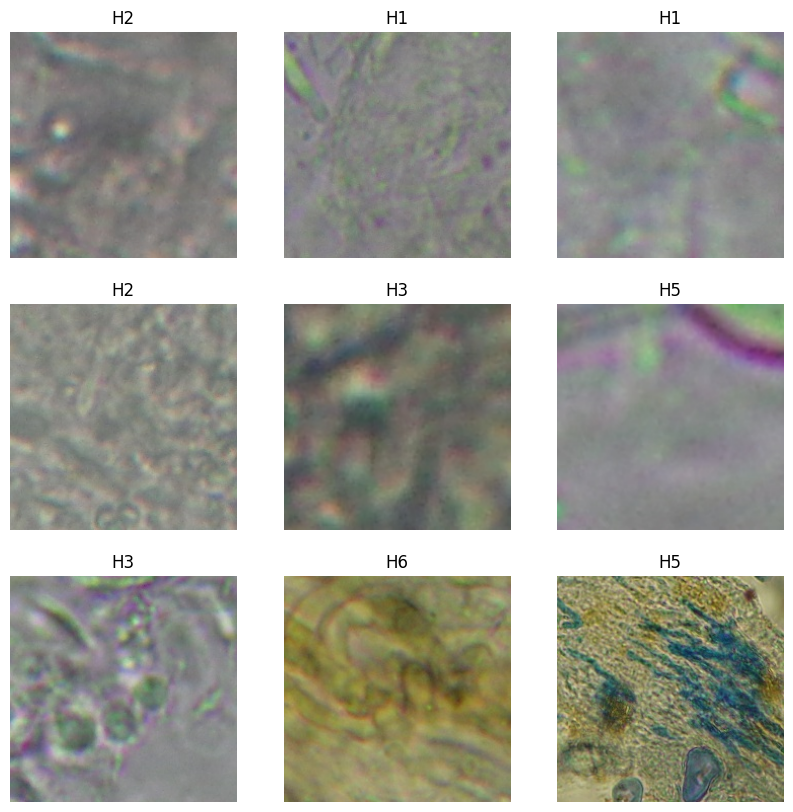

In [54]:
class_names = train_set.class_names 


plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1): #  1 batch of data
  for i in range(9): # each batch has 32 images and labels we only show 9 of them
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Comment based on images:
To my understanding, H5 class is like bubbles and is rounded, while H6 and H5 are more stretched and thiner.
Ama H5 class disinda bubbly yapida mantarlar da mevcut!!!

Configuring the datasets for better performance
We're going to cache the datasets, using cache() method before feeding the data to the model. It stores the elements of a dataset in memory or on disk and helps avoid redundant data loading during training.

Also, prefetch() methods overlaps data loading and model execution and prefetches batches in the background while the model is training on the current batch and helps reduce data loading latency and keeps the GPU or CPU busy.

In [55]:
AUTOTUNE = tf.data.AUTOTUNE #dynamically tuning the parallelism based on available system resources

train_ds = train_set.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = validation_set.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_set.cache().prefetch(buffer_size=AUTOTUNE)

Feature extraction using DenseNet
DenseNet-121 is a CNN architecture that belongs to the family of Densely Connected Convolutional Networks (DenseNets). The key characteristic of DenseNet architectures is the dense connectivity pattern, where each layer receives input from all preceding layers. This model attempts to solve the problem of vanishing gradients in deep CNN architecture by reusing features through a connection of each block with one another. 

In [58]:
# base model
# base model
densenet_base_model = DenseNet121(weights='/Users/erdem/model-playground/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

densenet_base_model.trainable = False


With include_top=True, the model includes the fully connected layers for classification (typically a few dense layers and a softmax output layer for multi-class classification). With include_top=False, you get only the convolutional part of the model, up to the last pooling layer, which outputs a 3D feature map.

In [59]:
# getting the result of applying densenet model
extracted_features = densenet_base_model.predict(train_set)

157/157 ━━━━━━━━━━━━━━━━━━━━ 113s 710ms/step


Using PCA(Principal Component Analysis--dimensionality reduction technique) to visualize the extracted features

DenseNet model (training_features) is a 4D array with the shape (batch_size, height, width, channels), we would need to flatten or reshape it to a 2D array before applying PCA

In [60]:
# finding the shapes of the model output
n_training, x, y, z = extracted_features.shape
print("Number of training samples:", n_training)
print("Height of each feature map:", x)
print("Width of each feature map:", y)
print("Number of channels in each feature map:", z)

Number of training samples: 5000
Height of each feature map: 7
Width of each feature map: 7
Number of channels in each feature map: 1024


as we recall from the begining we have 5000 training pictures. the output of the DenseNet121 model transform them from (224,224,3) shape into (7,7,1024)(a reduction in the height and width of pictures and increase in the number of chaneels)

In [61]:
#reduce the dimensionality to 2 principal components.
pca_2 = decomposition.PCA(n_components = 2)

#  reshapeing the train_features array into a 2D array
X = extracted_features.reshape((n_training, -1))
pca_2.fit(X)


transformed_data = pca_2.transform(X) 
print("the shape of the transformed data: ", transformed_data.shape)
print("the percentage of variance explained by each of the selected components ",
      np.round(pca_2.explained_variance_ratio_,3)*100)


the shape of the transformed data:  (5000, 2)
the percentage of variance explained by each of the selected components  [28.2      15.700001]


We have 5000 rows(training observations), now each one of these training examples(that belongs to a specific class) has only two dimensions(previously, they had 771024 dimensions). now, we can visualize them using a scatter plot

2024-11-13 15:07:14.076368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


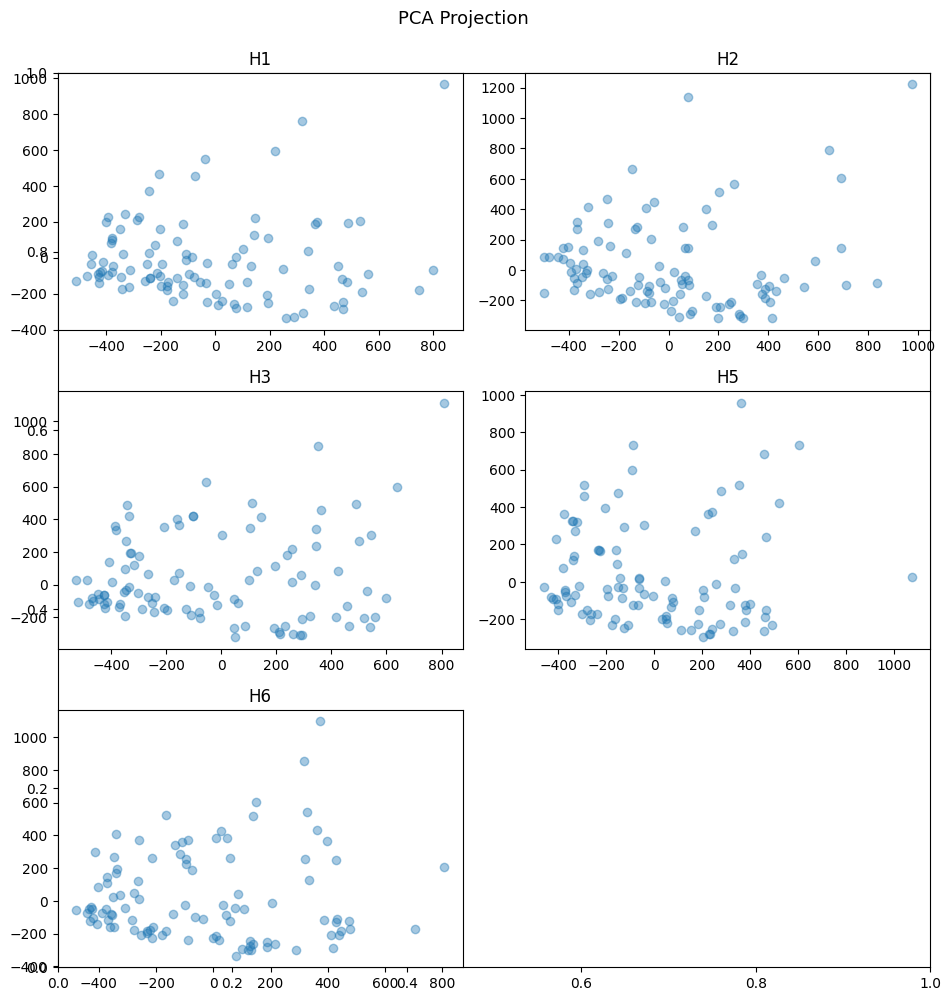

In [62]:
first_component = transformed_data[:,0]
second_component = transformed_data[:,1]
training_labels = np.concatenate([label for pic, label in train_set], axis=0)

# creating a separeted scatter plot for each class
plt.subplots(figsize=(10,10))
for i, class_name in enumerate(class_names):
    plt.subplot(3, 2, i + 1)
    plt.scatter(first_component[training_labels == i][:100], # showing 100 examples of each class
                second_component[training_labels == i][:100],
                label = class_name, alpha=0.4)
    plt.title(class_name)

plt.tight_layout()
plt.suptitle("PCA Projection", y = 1.02, fontsize = 13)
plt.show()

By comparing the outcome of the densent model after applying PCA, we tend to find whether we can find some similiarities (using a simple 2D scatter plot) by human-eye inspection or not. H2, H3,H5 and H6 have shown similar behaviors, while H1 is the most distinctive class for this model.

Data Augmentation
In data augmentation,we create synthetic data from the real data to improve the generalization and robustness of our model. In fact, we feed our model with different versions of the same file, so it won't get sensitive to a specific direction, size, gesture, or ...(any pattern that is not related to the class of data). In fact, we are vaccinating our model for different versions of the same virus!

I apply random rotation, zoom, flipp, shifting image up and down, change in contrast and brightness .

In [63]:
data_augmentation =  tf.keras.Sequential([
    layers.RandomRotation(factor=0.2),  # Random rotation (up to 20%)
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),  # Random zoom
    layers.RandomFlip(mode="horizontal"),  # Random horizontal flip
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Random translation
    layers.RandomContrast(factor=0.2),  # Random contrast adjustment
    layers.RandomBrightness(factor=0.2),  # Random brightness adjustment
])

2024-11-13 15:07:22.121097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


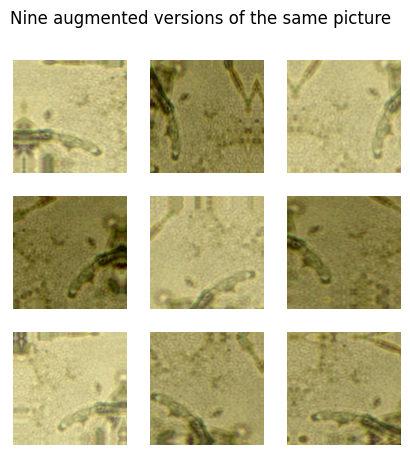

In [64]:
plt.figure(figsize = (5,5))
for image, _ in train_set.take(1):
    first_image = image[2] # selecting the second image as an example
    for i in range(9): #apply the augmentation layer 9 times      
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0)) 
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')
    
plt.suptitle('Nine augmented versions of the same picture', fontsize=12)
plt.show()

Transfer learning using DenseNet
At this step, we add a "top" to the previous model to flatten the outcome (extracted features) and find their predicted classes using a fully connected network. I create the whole model using keras functional API. Two new layers are used in this model:

Droput: during training, random neurons are "dropped out"(switched off) with a certain probability (dropout rate). This helps to prevent the neurons at next layers rely too much on the previous neurons and improves model's generalization.
Global Average Pooling: global average pooling computes the average value of each feature across the entire spatial dimensions. It is usually used to replace the flatten + dense layer at the top of the model.

In [65]:
# creating layers
densenet_base_model = DenseNet121(weights='/Users/erdem/model-playground/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)
densenet_base_model.trainable = False
global_average_layer = layers.GlobalAveragePooling2D()


# building the model
inputs = tf.keras.Input(shape=(224, 224, 3))
augmented = data_augmentation(inputs)
features_extracted = densenet_base_model(augmented)
avg_pooling = global_average_layer(features_extracted)
dropout = tf.keras.layers.Dropout(0.5)(avg_pooling)
outputs = layers.Dense(5, activation='softmax')(dropout)
model_densenet = tf.keras.Model(inputs, outputs)

In the next step, I compile the model using "sparse_categorical_crossentropy" since I haven't one-hot encoded the y labels previously.

In [66]:
# compiling the model using Adam optimizer 
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model_densenet.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
EPOCHS = 20

Before fitting the data, I create two callbacks for the model.

early_stopping: to avoid overfitting on the training data by monitoring the loss of validation data.
lr_plateau: to reduce the learning rate if the validation loss does not improve for 5 consecutive epochs. in this scenario, the learning rate will be adjuste by multipying 0.5. the min value for learning rate will be 1e-7.

In [67]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.5, min_lr=1e-7)

In [69]:
history_densenet = model_densenet.fit(train_ds, validation_data = val_ds,
                                     epochs = EPOCHS,
                                     callbacks = [early_stopping,lr_plateau])

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 147s 908ms/step - accuracy: 0.1870 - loss: 8.6605 - val_accuracy: 0.3204 - val_loss: 2.4181 - learning_rate: 1.0000e-04
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 144s 917ms/step - accuracy: 0.2534 - loss: 6.2158 - val_accuracy: 0.3804 - val_loss: 2.2201 - learning_rate: 1.0000e-04
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 147s 937ms/step - accuracy: 0.2974 - loss: 5.1713 - val_accuracy: 0.4283 - val_loss: 1.9937 - learning_rate: 1.0000e-04
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 154s 983ms/step - accuracy: 0.3057 - loss: 4.4991 - val_accuracy: 0.4449 - val_loss: 1.8392 - learning_rate: 1.0000e-04
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 147s 939ms/step - accuracy: 0.3378 - loss: 4.0370 - val_accuracy: 0.4405 - val_loss: 1.7135 - learning_rate: 1.0000e-04
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 148s 942ms/step - accuracy: 0.3455 - loss: 3.7660 - val_accuracy: 0.4394 - val_loss: 1.6538 - learning_rate: 1.0000e-04
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 

In [70]:
model_comparison = {}
model_comparison['densenet'] = pd.DataFrame(history_densenet.history)


Plotting the training and validation curves
Here I create a function to show the performance of models to better understand what happens inside them while training.

In [72]:
def plot_performance(model_name, epochs = EPOCHS):
  dataframe = model_comparison[model_name]
  plt.figure(figsize = (12,3))

  plt.subplot(1,2,1)
  plt.plot(dataframe[["val_loss", "loss"]])
  plt.xticks(np.arange(0,epochs,5), np.arange(1, epochs+1,5))
  plt.title("Loss")
  plt.legend(["val_loss", "loss"])

  plt.subplot(1,2,2)
  plt.plot(dataframe[["val_accuracy", "accuracy"]])
  plt.legend(["val_accuracy", "accuracy"], loc = "lower right")
  plt.xticks(np.arange(0,epochs,5), np.arange(1, epochs+1,5))
  plt.title("Accuracy")

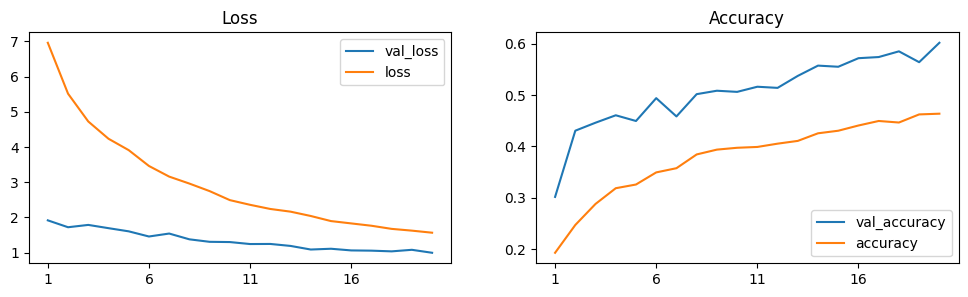

In [ ]:
plot_performance('densenet')

Transfer learning using VGG16
VGG16 consists of 13 convolutional layers and 3 fully connected layers(in total, 16, VGG16). The architecture is characterized by the repeated use of 3x3 convolutional filters, which helps maintain a small receptive field and allows for a deeper network.

In [73]:
# loading the base model
vgg16_base_model = VGG16(input_shape=(224,224,3), include_top=False, weights='/Users/erdem/model-playground/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
vgg16_base_model.trainable = False # freezing base_model's layers
global_average_layer = layers.GlobalAveragePooling2D()

# 
inputs = tf.keras.Input(shape=(224, 224, 3))
augmented = data_augmentation(inputs)
features_extracted = vgg16_base_model(augmented)
avg_pooling = global_average_layer(features_extracted)
dropout = tf.keras.layers.Dropout(0.3)(avg_pooling) #reduced the dropout rate to 0.3
outputs = layers.Dense(5, activation='softmax')(dropout)
model_vgg16 = tf.keras.Model(inputs, outputs)                                     
                                      
model_vgg16.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,717,253 (56.14 MB)

 Trainable params: 2,565 (10.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [74]:
# compiling the model just like before
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Define callbacks to improve training stability
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model_vgg16.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])


In [75]:
history_vgg16 = model_vgg16.fit(
    train_set, epochs=EPOCHS, validation_data=validation_set,
    callbacks = [early_stopping,lr_plateau])

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 624s 4s/step - accuracy: 0.2295 - loss: 3.5608 - val_accuracy: 0.2937 - val_loss: 1.9425 - learning_rate: 1.0000e-04
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 942s 6s/step - accuracy: 0.2577 - loss: 2.8636 - val_accuracy: 0.3671 - val_loss: 1.6207 - learning_rate: 1.0000e-04
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 456s 3s/step - accuracy: 0.3104 - loss: 2.4625 - val_accuracy: 0.4227 - val_loss: 1.4319 - learning_rate: 1.0000e-04
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 450s 3s/step - accuracy: 0.3475 - loss: 2.1281 - val_accuracy: 0.4694 - val_loss: 1.3085 - learning_rate: 1.0000e-04
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 450s 3s/step - accuracy: 0.3841 - loss: 1.9748 - val_accuracy: 0.5017 - val_loss: 1.2094 - learning_rate: 1.0000e-04
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 719s 5s/step - accuracy: 0.3991 - loss: 1.8360 - val_accuracy: 0.5384 - val_loss: 1.1407 - learning_rate: 1.0000e-04
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 451s 3s/step - acc

In [76]:
model_comparison["vgg16"] = pd.DataFrame(history_vgg16.history)


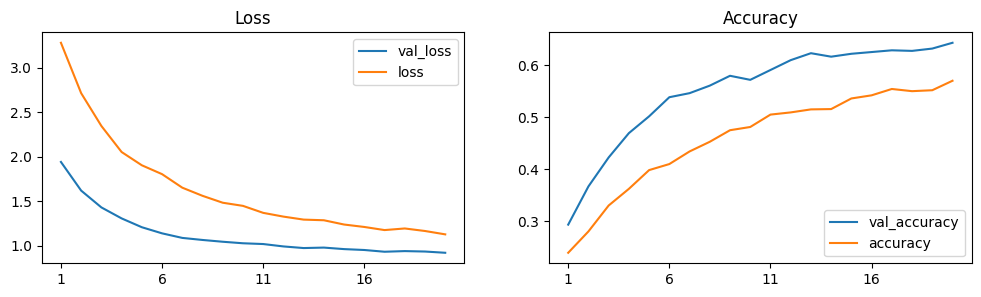

In [77]:
plot_performance("vgg16")


The loss and accuracy curve of the VGG16 model showed a smoother behavior. Let's check the accuracy score of both models on the test set to choose one of them:

In [78]:
vgg16_results = model_vgg16.evaluate(test_ds)
densenet_results = model_densenet.evaluate(test_ds)

29/29 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.6462 - loss: 0.8913
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 720ms/step - accuracy: 0.5289 - loss: 1.0587


In [ ]:
print("VGG16 model test loss and accuracy score(in order):", vgg16_results[0],vgg16_results[1], )
print("DenseNet model test loss and accuracy score(in order):", densenet_results[0],densenet_results[1])

VGG16 model test loss and accuracy score(in order): 0.8919267058372498 0.6518846750259399
DenseNet model test loss and accuracy score(in order): 1.058101773262024 0.5532150864601135


Although accuracy score is not a comprehensive measure for an imbalanced dataset with 5 classes, I use it as an early indicator to choose between the two models. As we expected, the VGG16 model that showed a smoother behavior got a higher accuracy score and lower loss in comparison to the DenseNet model.

Lets try to FINE TUNE VGG16 

Fine tuning, in most cases, is when we decide to unfreeze (some of the final and consecutive) layers of the base model(the model that we used for transfer learning) to make the model more specific to our task. As a result, we might get a higher performance score for our model.

In [81]:
# how many layers are in the base model?
print("Number of layers in the base model(VGG16): ", len(vgg16_base_model.layers))

vgg16_layers = [layer.name for layer in vgg16_base_model.layers]
print(vgg16_layers)

Number of layers in the base model(VGG16):  19
['input_layer_10', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']


There are 19 layers in this model. The last 4 layers are a new start after a pooling layer('block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool'). I select this part of the model to be fine tuned

In [82]:
# swithcing on all layers to be trainable
vgg16_base_model.trainable = True

# swithcing off(freezing) all layers except the last 4 layers
fine_tune_last = 4
for layer in vgg16_base_model.layers[:-fine_tune_last]:
    layer.trainable = False

Since we are training a larger model, it might overfit so fast to the training data. So it's recommended to use a lower learning rate. instead of 1e-4, I use 1e-5 as the new learning rate. other settings are the same as before for compiling the model:

In [83]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model_vgg16.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [84]:
model_vgg16.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,717,253 (56.14 MB)

 Trainable params: 7,081,989 (27.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Lets run the model 10 epochs for fine tuning and continue learning(from the last epoch).

In [85]:
fine_tune_epochs = 10
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model_vgg16.fit(train_set,
                         epochs=total_epochs,
                         initial_epoch=history_vgg16.epoch[-1],
                         validation_data=validation_set)


Epoch 20/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 535s 3s/step - accuracy: 0.5879 - loss: 1.0430 - val_accuracy: 0.6785 - val_loss: 0.8204
Epoch 21/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 1932s 12s/step - accuracy: 0.6545 - loss: 0.8861 - val_accuracy: 0.6830 - val_loss: 0.7698
Epoch 22/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 527s 3s/step - accuracy: 0.6774 - loss: 0.8057 - val_accuracy: 0.6930 - val_loss: 0.7268
Epoch 23/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 531s 3s/step - accuracy: 0.7049 - loss: 0.7524 - val_accuracy: 0.7264 - val_loss: 0.6709
Epoch 24/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 1612s 10s/step - accuracy: 0.7168 - loss: 0.6809 - val_accuracy: 0.7442 - val_loss: 0.6297
Epoch 25/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 4268s 27s/step - accuracy: 0.7427 - loss: 0.6398 - val_accuracy: 0.7253 - val_loss: 0.6428
Epoch 26/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 755s 5s/step - accuracy: 0.7475 - loss: 0.6091 - val_accuracy: 0.7564 - val_loss: 0.5962
Epoch 27/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 1127s 7s/step - accuracy: 0.7593 - loss: 0.

In [86]:
fine_tune_df = pd.DataFrame(history_fine.history)
model_comparison['vgg16_fineTuned'] = pd.concat([model_comparison['vgg16'],fine_tune_df]).reset_index()

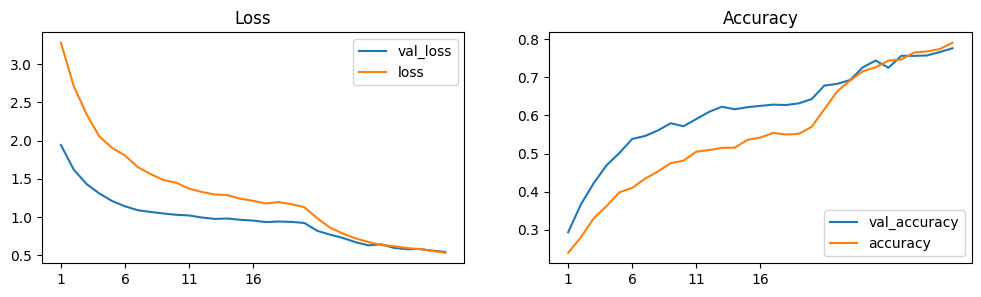

In [87]:
plot_performance('vgg16_fineTuned')


As we can see above Fune tuning decreased training loss very fast, but with a lower rate for the training set. This proccess also improved validation accuracy from 64.2% to 77.6%.

Measuring the final results

In [88]:
predictions = model_vgg16.predict(test_ds)
vgg16_fineTuned_results = model_vgg16.evaluate(test_ds)

29/29 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.7771 - loss: 0.5868


In [89]:
print("the VGG16 tuned model test loss and accuracy score(in order):", vgg16_fineTuned_results[0],
      vgg16_fineTuned_results[1] )

the VGG16 tuned model test loss and accuracy score(in order): 0.5440342426300049 0.7893570065498352


Model was capable of generalizing results to the test set also. It got 78.9% accuracy score on the test set with a low loss value(0.54) in comparions to the first epochs of the model.

Confusion Matrix

2024-11-14 00:47:07.623354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


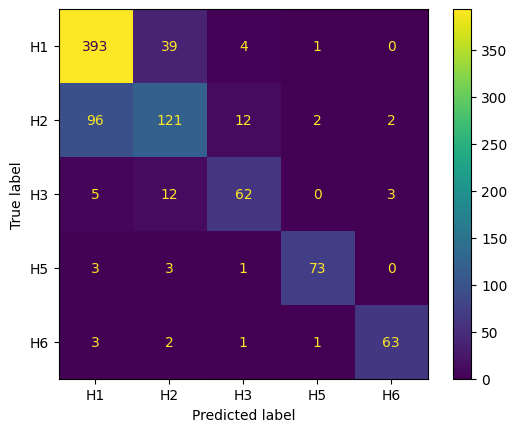

In [90]:
# true labels using test dataset
y_true = np.concatenate([label for pic, label in test_ds], axis=0)

# final predicted labels 
y_pred = np.argmax(predictions, axis=1)

# showing the confusion matrix of the second model
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                            display_labels=class_names)
disp.plot()
plt.show()

The confusion matrix shows the frequency of predictions for each actual class against each predicted class
H1 VE H2 ARASINDA BARIZ CONFUSION VAR!!!

REGULARLY HIGH ACCURACY FOR OTHER CLASSES
H6 COK IYI PREDICT EDILMIS

In [91]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

              precision    recall  f1-score   support

          H1      0.786     0.899     0.839       437
          H2      0.684     0.519     0.590       233
          H3      0.775     0.756     0.765        82
          H5      0.948     0.912     0.930        80
          H6      0.926     0.900     0.913        70

    accuracy                          0.789       902
   macro avg      0.824     0.797     0.808       902
weighted avg      0.784     0.789     0.782       902



Results
The model showed the highest precision score for the H6 class and the lowest for the H2 class.
if we consider f1 score as a measure for the overal performance of the model, our model's performance is as follow: H6, H5, H1, H3, and H2. for H2, the model's performance was just a little bit higher than 0.5.
The overall accuracy, as discussed, was 76.8% after 30 epochs.

What's NEXT?
We can run the tuned vgg16 model for a higher number of epochs like 50 or more
also, we can add a more advanced top to the base model. The top layers i used were the simplest ones for the structure.
We can test other base models like InceptionV3, MobileNet and ... and compare the results.